### Is it possible to predict the salary of a Data Scientist by looking at a few job parameters?

In [201]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import normalize
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.datasets import make_regression
from sklearn import metrics
from sklearn.model_selection import cross_validate, cross_val_score, RepeatedKFold, train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, mean_absolute_error, get_scorer_names, accuracy_score
from xgboost import XGBRegressor
from numpy import absolute
from sklearn.neighbors import KNeighborsRegressor

In [202]:
# Load the data
df = pd.read_csv('ds_salaries.csv')

In [203]:
# Take a look at the first five rows
df.head()

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [204]:
# check how many rows and columns there are in the dataset
df.shape

(607, 12)

In [205]:
# Check if there are any null-values and what datatype the columns have
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


In [206]:
# Seems like the column 'Unnamed: 0' is just a count of rows, I will just confirm this is the case.
df['Unnamed: 0'].nunique()

607

In [207]:
# deleting the unnamed column
df.drop(columns=['Unnamed: 0', 'salary_currency', 'salary'], inplace=True)

In [208]:
df['employment_type'].nunique()

4

In [209]:
df.describe()

,work_year,salary_in_usd,remote_ratio
count,607.000000,607.000000,607.00000
mean,2021.405272,112297.869852,70.92257
std,0.692133,70957.259411,40.70913
min,2020.000000,2859.000000,0.00000
25%,2021.000000,62726.000000,50.00000
50%,2022.000000,101570.000000,100.00000
75%,2022.000000,150000.000000,100.00000
max,2022.000000,600000.000000,100.00000


In [210]:
df.head()

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,US,50,US,L


### Exploratory Data Analysis:

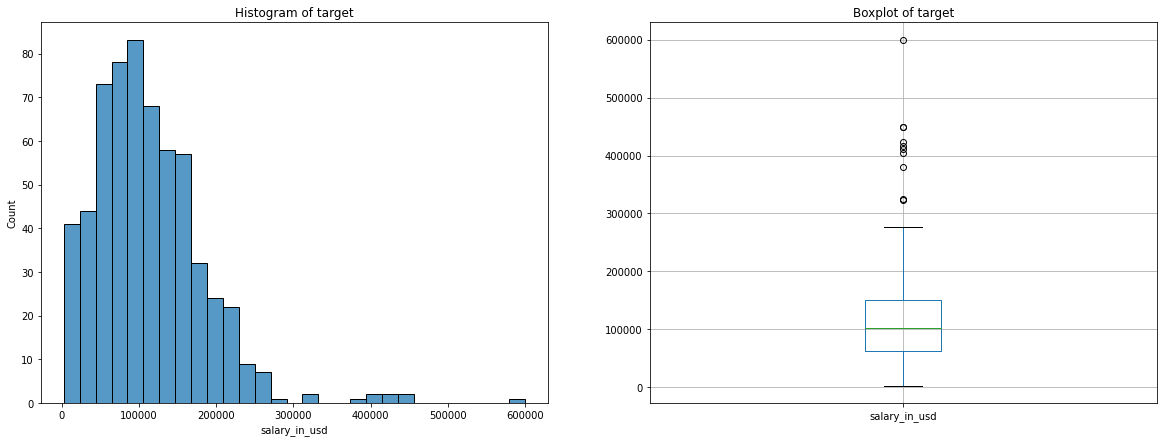

In [211]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))

sns.histplot(df['salary_in_usd'], ax=ax1)
ax1.set_title('Histogram of target')
df.boxplot(column='salary_in_usd', ax=ax2)
ax2.set_title('Boxplot of target');

In [212]:
# The salaries seem to be right skewed with some outliers above 300.000 usd.

In [213]:
original_shape = df.shape
print(f'Original rows and columns: {original_shape}')

Original rows and columns: (607, 9)


In [214]:
df.drop(df[(df['salary_in_usd'] > 300000)].index, inplace=True)

In [215]:
print(f'Original rows and columns: {original_shape}')
print(f'Current rows and columns: {df.shape}')

Original rows and columns: (607, 9)
Current rows and columns: (597, 9)


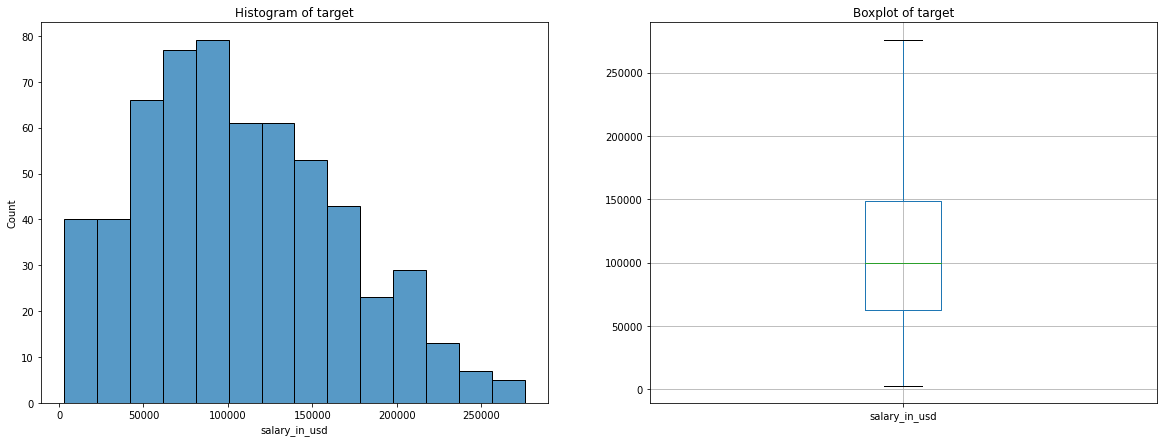

In [216]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))

sns.histplot(df['salary_in_usd'], ax=ax1)
ax1.set_title('Histogram of target')
df.boxplot(column='salary_in_usd', ax=ax2)
ax2.set_title('Boxplot of target');

In [217]:
df.head()

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,US,50,US,L


In [218]:
ord_enc = OrdinalEncoder()
df[["experience_level", "employment_type", "job_title", "employee_residence", "company_location", "company_size"]] = ord_enc.fit_transform(df[["experience_level", "employment_type", "job_title", "employee_residence", "company_location", "company_size"]])
df.head()

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,2.0,2.0,21.0,79833,14.0,0,12.0,0.0
1,2020,3.0,2.0,40.0,260000,32.0,0,29.0,2.0
2,2020,3.0,2.0,7.0,109024,20.0,50,18.0,1.0
3,2020,2.0,2.0,46.0,20000,23.0,0,20.0,2.0
4,2020,3.0,2.0,37.0,150000,55.0,50,48.0,0.0


In [219]:
print('Correlation between the target compared to the other features')
corr = df.corr()
corr.sort_values(['salary_in_usd'], ascending = False, inplace = True)
print(corr.salary_in_usd)

Correlation between the target compared to the other features
salary_in_usd         1.000000
employee_residence    0.484877
company_location      0.459563
experience_level      0.408545
work_year             0.266883
remote_ratio          0.134026
job_title             0.105263
employment_type      -0.084393
company_size         -0.127788
Name: salary_in_usd, dtype: float64


In [220]:
# Normalizing the data
target_name = 'salary_in_usd'
robust_scaler = RobustScaler()
X = df.drop('salary_in_usd', axis=1)
X = robust_scaler.fit_transform(X)
y = df[target_name]

In [221]:
y_pred_null = y.mean()
null_rmse = -1*mean_squared_error(y_pred=np.repeat(y_pred_null, y.size), y_true=y, squared=False)
null_mape = -1*mean_absolute_percentage_error(y_pred=np.repeat(y_pred_null, y.size), y_true=y)

In [235]:
rf = RandomForestRegressor(n_estimators=50, max_depth=15, random_state=2, n_jobs=-1)
rf_rmse = cross_validate(estimator=rf,X=X,y=y,
                                    scoring='neg_root_mean_squared_error',
                                    cv=10, n_jobs=-1)['test_score']
rf_mape = cross_validate(estimator=rf,X=X,y=y,
                                    scoring='neg_mean_absolute_percentage_error', 
                                    cv=10, n_jobs=-1)['test_score']
rf_r2 = cross_validate(estimator=rf,X=X,y=y,
                                    scoring='r2', 
                                    cv=10, n_jobs=-1)['test_score']


knn = KNeighborsRegressor(n_neighbors=20, weights='distance', metric='euclidean', n_jobs=-1)
knn_rmse = cross_validate(estimator=knn,X=X,y=y,
                                    scoring='neg_root_mean_squared_error', 
                                    cv=10, n_jobs=-1)['test_score']
knn_mape = cross_validate(estimator=knn,X=X,y=y,
                                    scoring='neg_mean_absolute_percentage_error', 
                                    cv=10, n_jobs=-1)['test_score']
knn_r2 = cross_validate(estimator=knn,X=X,y=y,
                                    scoring='r2', 
                                    cv=10, n_jobs=-1)['test_score']                                    


AdaBoost = AdaBoostRegressor(n_estimators=50, learning_rate=1.0, random_state=2)  
AdaBoost_rmse = cross_validate(estimator=AdaBoost,X=X,y=y,
                                    scoring='neg_root_mean_squared_error', 
                                    cv=10, n_jobs=-1)['test_score']
AdaBoost_mape = cross_validate(estimator=AdaBoost,X=X,y=y,
                                    scoring='neg_mean_absolute_percentage_error', 
                                    cv=10, n_jobs=-1)['test_score']
AdaBoost_r2 = cross_validate(estimator=AdaBoost,X=X,y=y,
                                    scoring='r2', 
                                    cv=10, n_jobs=-1)['test_score']

XGBoost = XGBRegressor()
XGBoost_rmse = cross_validate(estimator=XGBoost, X=X, y=y, scoring='neg_root_mean_squared_error', 
                                    cv=10, n_jobs=-1, return_estimator=True)['test_score']
XGBoost_mape = cross_validate(estimator=XGBoost,X=X,y=y,
                                    scoring='neg_mean_absolute_percentage_error', 
                                    cv=10, n_jobs=-1)['test_score']
XGBoost_r2 = cross_validate(estimator=XGBoost,X=X,y=y,
                                    scoring='r2', 
                                    cv=10, n_jobs=-1)['test_score']


In [223]:
r2_models =  pd.DataFrame({'KNN':knn_r2,
                           'RandomForest': rf_r2,
                           'AdaBoost':AdaBoost_r2,
                           'XGBoost':XGBoost_r2})
r2_models

,KNN,RandomForest,AdaBoost,XGBoost
0,0.287599,0.458854,0.365468,0.343813
1,0.305826,0.540044,0.506880,0.524829
2,0.312147,0.477196,0.264234,0.509199
3,0.485754,0.656614,0.460725,0.676229
4,0.264934,0.431215,0.211020,0.368069
5,-0.111102,-0.004347,0.284442,0.051163
6,0.396881,0.411385,0.395027,0.429777
7,0.382825,0.526885,0.420947,0.517644
8,0.325889,0.517043,0.466486,0.487912
9,0.182558,0.166794,0.109942,0.167871


In [224]:
mape_models = -1*pd.DataFrame({'KNN':knn_mape,
                           'RandomForest': rf_mape,
                           'AdaBoost':AdaBoost_mape,
                           'XGBoost': XGBoost_mape,
                           'NULL': null_mape})
mape_models

,KNN,RandomForest,AdaBoost,XGBoost,NULL
0,1.262529,0.627099,1.038323,0.690775,1.14629
1,0.878444,0.690630,0.709110,0.583841,1.14629
2,1.465966,0.929492,1.437658,0.951051,1.14629
3,1.630521,1.267708,1.863637,1.165116,1.14629
4,0.622117,0.429506,0.646725,0.425027,1.14629
5,0.289492,0.300242,0.268653,0.283296,1.14629
6,0.350276,0.343728,0.335443,0.314370,1.14629
7,0.558098,0.377709,0.483533,0.385029,1.14629
8,0.592782,0.296767,0.458948,0.289196,1.14629
9,0.343127,0.344634,0.425090,0.332682,1.14629


In [225]:
rmse_models = -1*pd.DataFrame({'KNN':knn_rmse,
                           'RandomForest': rf_rmse,
                           'AdaBoost':AdaBoost_rmse,
                           'XGBoost':XGBoost_rmse,
                           'NULL':null_rmse})
rmse_models

,KNN,RandomForest,AdaBoost,XGBoost,NULL
0,45788.059349,39906.835005,43213.234310,43944.422025,58506.454267
1,53036.619212,43171.751507,44701.061594,43880.005819,58506.454267
2,52449.307856,45725.800618,54245.263244,44304.164681,58506.454267
3,46151.269517,37712.845415,47261.076005,36619.919186,58506.454267
4,37823.844716,33271.841674,39186.421823,35070.133163,58506.454267
5,49753.100117,47302.605919,39926.888763,45976.821542,58506.454267
6,40369.131884,39880.791277,40431.144946,39252.794379,58506.454267
7,47662.238338,41730.519468,46166.763839,42136.104580,58506.454267
8,44063.090833,37296.109323,39199.658714,38404.463003,58506.454267
9,44874.300040,45304.938990,46825.069827,45275.631090,58506.454267


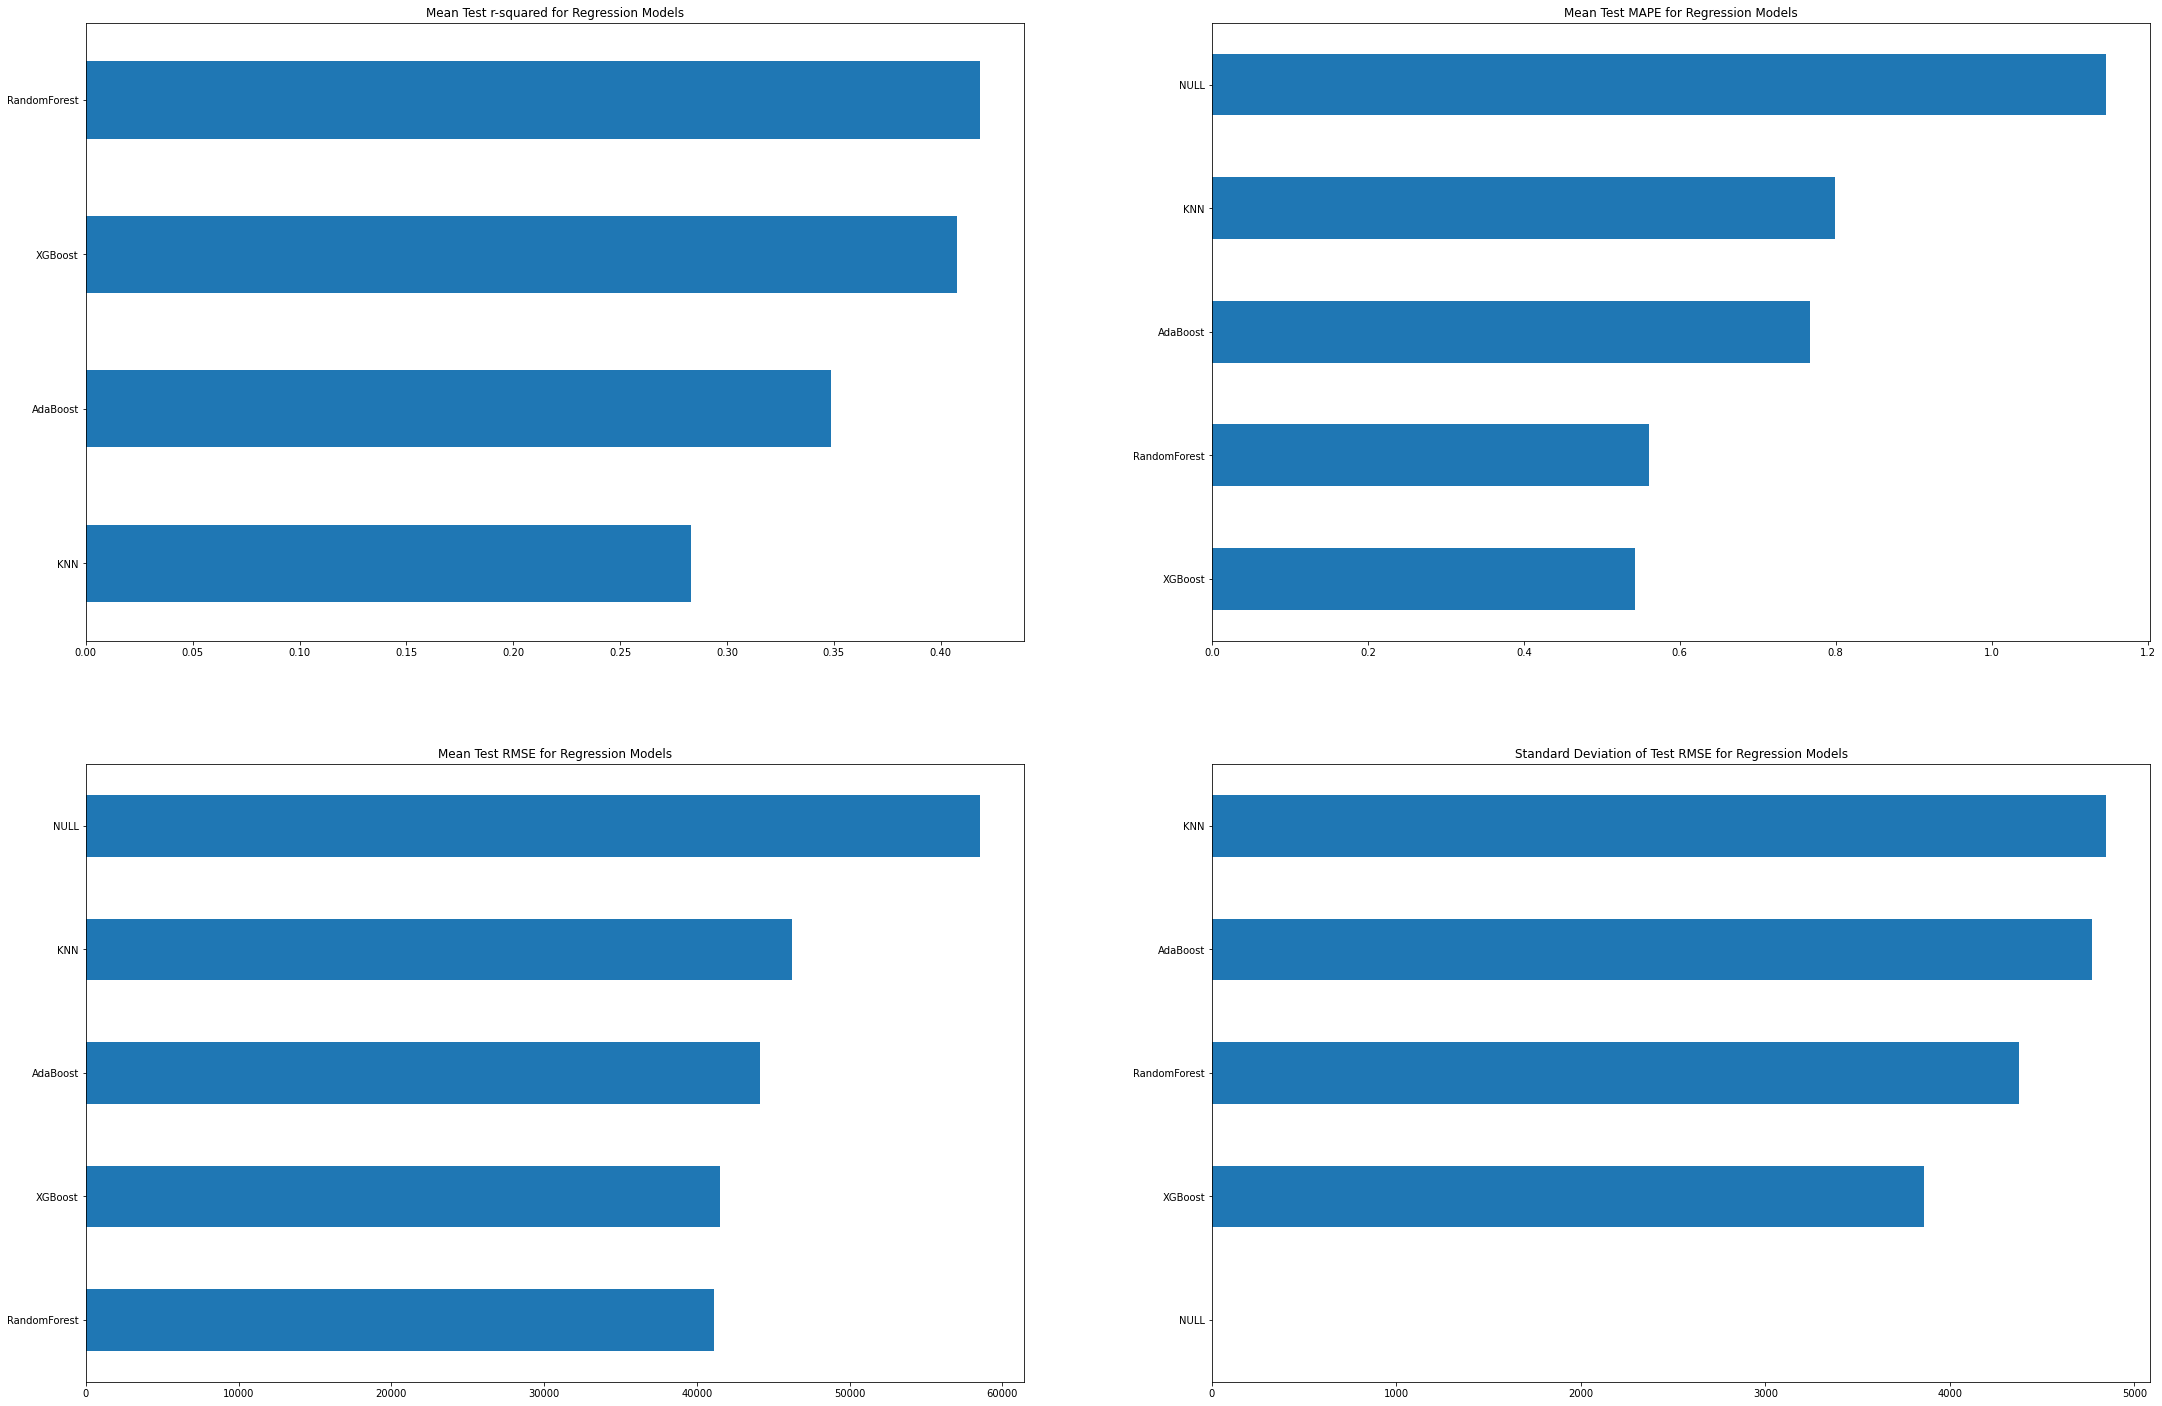

In [226]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(37,25))

r2_models.mean().sort_values().plot(kind='barh', ax=ax1)
ax1.set_title('Mean r-squared for all regression models')
mape_models.mean().sort_values().plot(kind='barh', ax=ax2)
ax2.set_title('Mean MAPE for all regression models')
rmse_models.mean().sort_values().plot(kind='barh', ax=ax3)
ax3.set_title('Mean RMSE for all regression models')
rmse_models.std().sort_values().plot(kind='barh', ax=ax4)
ax4.set_title('Standard Deviation of RMSE for all regression models');